In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

import networkx as nx

In [57]:
passagers = pd.read_csv("../data_chall_alstom/passagers.csv")
print(passagers.info())
plan_metro = pd.read_csv("../data_chall_alstom/plan_du_métro.csv")
print(plan_metro.info())
position_gps = pd.read_csv("../data_chall_alstom/position_gps_des_stations_de_métro.csv")
print(position_gps.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93942 entries, 0 to 93941
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   de      93942 non-null  object
 1   vers    93942 non-null  object
 2   nombre  93942 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   de Ligne      1010 non-null   object
 1   de Station    1010 non-null   object
 2   vers Ligne    1010 non-null   object
 3   vers Station  1010 non-null   object
dtypes: object(4)
memory usage: 31.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Station  385 non-null    object
 1   GPS      385 non-null    object
d

### Mis en forme des jeu de données

In [62]:
plan_metro_ligne = plan_metro[plan_metro["de Station"]!=plan_metro["vers Station"]]
position_gps['lat'], position_gps['lng'] = zip(*position_gps['GPS'].apply(lambda x: x.split(',')))


In [64]:
stations=[]
"""
ligne_nb = list(range(1,15))
ligne_nb=[chr(x) for x in ligne_nb]
ligne_nb.append("3bis")
ligne_nb.append("7bis")
"""
ligne_nb=["1","2","3","3bis","4","5","6","7","8","9","10","11","12","13","14","7bis"]

for ligne in ligne_nb :
    liste_coord=[]
    df_lignei=plan_metro_ligne[plan_metro_ligne["de Ligne"]==ligne]
    station = df_lignei["de Station"].unique()

    for st in station:
        if not(position_gps[position_gps['Station']==st].empty):
            liste_coord.append([float(position_gps[position_gps['Station']==st].iat[0,3]), float(position_gps[position_gps['Station']==st].iat[0,2])])

        
    
    if ligne!="8":
        pop=liste_coord.pop()
        if ligne=="1" :
            liste_coord.insert(0,pop)
    stations.append({'coordinates' : liste_coord, 'type': 'LineString'})

plan_ligne = pd.DataFrame()
plan_ligne["ligne"] = ligne_nb
plan_ligne["station"] = stations

### Representation graphique du reseau

In [61]:
ligne_1=plan_ligne.loc[7]
idf_map = folium.Map(location=[48.868, 2.365], zoom_start=12, tiles='Cartodb dark_matter')


for segment in plan_ligne["station"]:
    gjson = folium.features.GeoJson(segment,
                                    style_function = lambda x: {'color': '#ED6852',
                                                                'weight': 1.5})
    idf_map.add_child(gjson)


for i, v in position_gps.iterrows():
    folium.CircleMarker(location=[v['lat'], v['lng']],
                        radius=1.2,
                        color='#FFFFF0',
                        fill_color='#FFFFFF',
                        fill=True).add_to(idf_map)
idf_map

### Creation de la matrice

In [65]:
import math

#On calcule la distance avec la formule de Haversine
def calcul_distance(station1, station2):
    coord_station1 = position_gps.loc[position_gps["Station"] == station1, "GPS"].iloc[0]
    coord_station2 = position_gps.loc[position_gps["Station"] == station2, "GPS"].iloc[0]
    lat1 , lon1 = map(float, coord_station1.split(", "))
    lat2 , lon2 = map(float, coord_station2.split(", "))
    # Rayon de la Terre en kilomètres
    R = 6371.0
    
    # Convertir les degrés en radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Différences
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Distance
    distance = R * c
    return distance

def calcul_temps(station1,station2,vitesse):
    return round(calcul_distance(station1,station2)/vitesse*3600)

In [66]:
def creation_matrice(plan_metro, position):
    plan_metro_grouped = plan_metro.groupby("de Station")
    passagers_dict = passagers.set_index(["de", "vers"])["nombre"].to_dict()

    # Liste unique des stations
    liste_station = position["Station"].unique()

    # Initialisation d'un dictionnaire pour construire le graph
    graph_dict = {station: [] for station in liste_station}

    # Construction optimisée du graph
    for depuis in liste_station:
        lien = plan_metro_grouped.get_group(depuis)["vers Station"].unique() if depuis in plan_metro_grouped.groups else []

        # Créer une liste pour chaque station de départ
        for vers in liste_station:
            noeud = {
                "ligne": [],
                "temps": -1,
                "passager": passagers_dict.get((depuis, vers), -1) if depuis != vers else -1
            }

            if vers in lien:
                noeud["ligne"] = list(plan_metro[
                    (plan_metro["de Station"] == depuis) & 
                    (plan_metro["vers Station"] == vers)
                ]["de Ligne"])
                noeud["temps"] = calcul_temps(depuis, vers, 25)

            graph_dict[depuis].append(noeud)

    # Conversion en DataFrame
    graph = pd.DataFrame(graph_dict, index=liste_station)
    return graph

In [67]:
df=creation_matrice(plan_metro, position_gps)

In [68]:
df

,Boucicaut,Bourse,Bir-Hakeim,Argentine,Daumesnil,Église d'Auteuil,George V,Franklin D. Roosevelt,Europe,Jacques Bonsergent,...,Malakoff - Plateau de Vanves,Tolbiac,Victor Hugo,Poissonnière,Avron,Église de Pantin,Château d'Eau,Guy Môquet,Monceau,Rome
Boucicaut,"{'ligne': [], 'temps': -1, 'passager': -1}","{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 2}",...,"{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 8}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 8}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 5}"
Bourse,"{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': -1}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 5}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 5}","{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 4}",...,"{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 1}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 1}","{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 6}"
Bir-Hakeim,"{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 5}","{'ligne': [], 'temps': -1, 'passager': -1}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 1}","{'ligne': [], 'temps': -1, 'passager': 3}",...,"{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 5}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 5}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 8}","{'ligne': [], 'temps': -1, 'passager': 8}"
Argentine,"{'ligne': [], 'temps': -1, 'passager': 7}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': -1}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 1}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 8}","{'ligne': [], 'temps': -1, 'passager': 1}",...,"{'ligne': [], 'temps': -1, 'passager': 1}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 9}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 5}","{'ligne': [], 'temps': -1, 'passager': 3}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'passager': 4}","{'ligne': [], 'temps': -1, 'passager': 4}"
Daumesnil,"{'ligne': [], 'temps': -1, 'passager': 8}","{'ligne': [], 'temps': -1, 'passager': 6}","{'ligne': [], 'temps': -1, 'passager': 2}","{'ligne': [], 'temps': -1, 'p

In [ ]:
def heatmap():

In [ ]:
print(df["Grands Boulevards"][])

{'ligne': [], 'temps': -1, 'passager': 1}


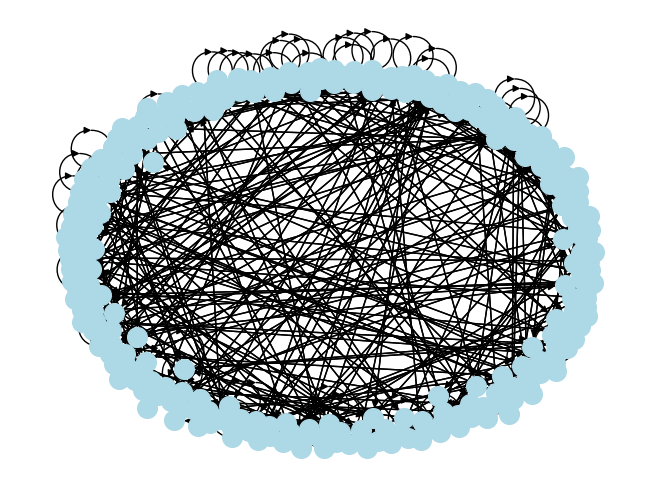

In [86]:
G = nx.DiGraph()  # Graph orienté (utilisez nx.Graph() si non orienté)

# Parcours du DataFrame pour ajouter des arêtes
for depuis in df.index:  # Lignes
    for vers in df.columns:  # Colonnes
        info = df.loc[depuis, vers]
        if info["ligne"]:  # Si la liste 'ligne' n'est pas vide
            # Ajout d'une arête avec les attributs 'ligne' et 'passager'
            G.add_edge(depuis, vers, ligne=info["ligne"], passager=info["passager"])

# Visualisation (optionnel)
pos = nx.spring_layout(G,12)  # Positionnement des nœuds
nx.draw(G, pos, with_labels=False, node_color="lightblue", node_size=200, font_size=10)
edge_labels = nx.get_edge_attributes(G, "ligne")
#nx.draw_networkx_edge_labels(G, pos, edge_labels={k: str(v) for k, v in edge_labels.items()})
plt.show()